<a href="https://colab.research.google.com/github/andysingal/mobile-classification/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Description

XYZ has started their own mobile company. They want to fight hard battles with big companies like Apple, Samsung, etc. In this competitive mobile market, you cannot simply imagine things. To solve this problem you are collecting data on mobile sales of various companies. They want to find some connection between mobile features (eg: - RAM, Internal Memory, etc.) and their sales value. But they are not very good at Machine Learning. So they need your help to solve this problem. In this case, you do not need to predict the actual price but a price list that shows how high the price is.

##Data Description

The data is divided into 2 groups:
• Training Set (train.csv) 
• Test Set (test.csv) 
The training set should be used to build learning models for your machine. In the training set, we provide the result (also known as a target label or class) for each mobile data point. A test set should be used to see how well your model is performing on intangible data. In the test set, we do not provide the result (targeted variable) of each mobile data point of sale. For each data point in the test, use a trained model to predict the price range.


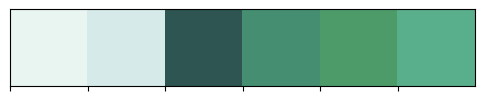

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

#color pallet and theme
import matplotlib.colors

colors = ["#e9f5f0","#d5eae9","#2e5551",'#468e71','#4d9b68','#59ae8c']
colors2 = ["#2e5551",'#468e71','#4d9b68','#59ae8c', "#e9f5f0","#d5eae9"]
cmap = matplotlib.colors.ListedColormap(colors2)

sns.palplot(sns.color_palette(colors))


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [27]:
DATA_FILE = 'mobile-price-classification/train.csv'
df = pd.read_csv(DATA_FILE)
#Drop Redundant column 
df = df.loc[:, df.columns!='Unnamed: 0']
df = df.rename(columns = {'blue': 'Bluetooth',
                          'battery_power': 'Battery_power',
                          'clock_speed': 'Clock_speed',
                          'dual_sim': 'Dual_sim',
                          'four_g': '4G_Network',
                          'int_memory':'Internal_memory',
                          "m_dep": "depth",
                          "mobile_wt": "weight",
                          "pc": "primary_camera_megapixels",
                          'n_cores': 'Number of processor_cores',
                          'px_height':'Pixel_Resolution_Height',
                          'px_width': 'Pixel_Resolution_Width',
                          "fc": "front_camera_megapixels",
                          "sc_h": "screen_height",
                          "sc_w": "screen_width",
                          "three_g": "3G_Network",
})
df= df.reset_index(drop=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Battery_power              1500 non-null   int64  
 1   Bluetooth                  1500 non-null   int64  
 2   Clock_speed                1500 non-null   float64
 3   Dual_sim                   1500 non-null   int64  
 4   front_camera_megapixels    1500 non-null   int64  
 5   4G_Network                 1500 non-null   int64  
 6   Internal_memory            1500 non-null   int64  
 7   depth                      1500 non-null   float64
 8   weight                     1500 non-null   int64  
 9   Number of processor_cores  1500 non-null   int64  
 10  primary_camera_megapixels  1500 non-null   int64  
 11  Pixel_Resolution_Height    1500 non-null   int64  
 12  Pixel_Resolution_Width     1500 non-null   int64  
 13  ram                        1500 non-null   int64

,Battery_power,Bluetooth,Clock_speed,Dual_sim,front_camera_megapixels,4G_Network,Internal_memory,depth,weight,Number of processor_cores,primary_camera_megapixels,Pixel_Resolution_Height,Pixel_Resolution_Width,ram,screen_height,screen_width,talk_time,3G_Network,touch_screen,wifi,price_range
0,1151,1,2.9,1,0,0,31,0.6,128,8,1,1022,1560,2377,18,8,13,0,1,0,2
1,1065,0,1.7,1,4,1,48,0.3,162,6,8,1188,1948,265,8,0,12,1,0,0,0
2,1375,0,2.9,0,2,0,20,0.4,147,6,7,596,679,3847,8,0,12,1,0,1,3
3,1329,1,1.0,0,1,0,52,0.9,181,6,2,1053,1458,1228,8,6,6,1,0,1,1
4,1521,1,1.6,0,5,1,62,0.3,143,1,9,678,1630,3555,5,2,19,1,0,0,3


In [38]:
df.iloc[:, :-1].describe().T.sort_values(by='std', ascending = False)\
                          .style.background_gradient(cmap="Greens")\
                          .bar(subset=["max"], color='#F8766D')\
                          .bar(subset=["mean"], color='#00BFC4')

,count,mean,std,min,25%,50%,75%,max
ram,1500.000000,2113.516000,1079.558518,256.000000,1210.750000,2102.500000,3056.250000,3998.000000
Pixel_Resolution_Height,1500.000000,654.626667,441.496076,0.000000,299.750000,585.000000,952.250000,1960.000000
Battery_power,1500.000000,1230.742000,440.517687,501.000000,838.750000,1209.000000,1611.750000,1998.000000
Pixel_Resolution_Width,1500.000000,1263.805333,428.900661,500.000000,888.750000,1262.000000,1643.500000,1997.000000
weight,1500.000000,140.582667,35.535762,80.000000,109.000000,141.000000,171.000000,200.000000
Internal_memory,1500.000000,32.067333,18.179598,2.000000,16.000000,32.000000,48.000000,64.000000
primary_camera_megapixels,1500.000000,9.870000,6.092880,0.000000,4.000000,10.000000,15.000000,20.000000
talk_time,1500.000000,10.860667,5.506614,2.000000,6.000000,11.000000,16.000000,20.000000
front_camera_megapixels,1500.000000,4.361333,4.367549,0.000000,1.000000,3.000000,7.000000,19.000000
screen_width,1500.000000,5.797333,4.366956,0.000000,2.000000,5.000000,9.000000,18.000000


## Checking for Null Values, Duplicated Rows and Whitespaces within columns

In [36]:
#Checking for Null Values, Duplicated Rows and Whitespaces within columns
def check(case, df):
  if case == 'null':
    return df.isnull().sum()
  elif case == 'duplicate':
    return df.duplicated().sum()
  elif case == 'whitespace':
    return [ i for i in df.columns if i.startswith(' ') or i.endswith(' ')]   
  elif case == 'outlier':
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr 
    upper_bound = q3 + 1.5*iqr 
    print('Upper Bound Value : {}'. format(upper_bound),'\n')
    print('Lower Bound Value : {}'. format(lower_bound)) 


In [34]:
print(check('null', df))
check('duplicate', df)

Battery_power                0
Bluetooth                    0
Clock_speed                  0
Dual_sim                     0
front_camera_megapixels      0
4G_Network                   0
Internal_memory              0
depth                        0
weight                       0
Number of processor_cores    0
primary_camera_megapixels    0
Pixel_Resolution_Height      0
Pixel_Resolution_Width       0
ram                          0
screen_height                0
screen_width                 0
talk_time                    0
3G_Network                   0
touch_screen                 0
wifi                         0
price_range                  0
dtype: int64


0

In [37]:
check('whitespace', df)

[]